In [ ]:
from google.colab import drive

In [ ]:
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
# ===============================================
# 📦 Import Required Libraries
# ===============================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import gc
import warnings
warnings.filterwarnings('ignore')

# ML Models
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report, roc_auc_score,
    confusion_matrix, precision_recall_curve,
    average_precision_score
)

# GPU Models
import lightgbm as lgb
from xgboost import XGBClassifier

# CatBoost
!pip install catboost
from catboost import CatBoostClassifier

# Stacking
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression

# SHAP Explainability
import shap

sns.set(style="whitegrid", palette="muted")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.0 MB/s eta 0:00:00


In [ ]:
# ===============================================

# 📥 Load the IEEE-CIS Data

# ===============================================

train_trans = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/train_transaction.csv")

train_id = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/train_identity.csv")

print("Transaction Data Shape:", train_trans.shape)

print("Identity Data Shape:", train_id.shape)



Transaction Data Shape: (590540, 394)
Identity Data Shape: (144233, 41)


In [ ]:
# Merge datasets
train = train_trans.merge(train_id, on="TransactionID", how="left")
del train_trans, train_id

In [ ]:
# -----------------------------
# 2️⃣ Keep only important columns
# -----------------------------
# These columns are high-impact for fraud detection
columns_to_keep = [
    'TransactionID', 'TransactionDT', 'TransactionAmt', 'ProductCD',
    'card1', 'card2', 'card3', 'card4', 'card5', 'card6',
    'addr1', 'addr2', 'P_emaildomain', 'R_emaildomain',
    'DeviceType', 'DeviceInfo', 'isFraud'
] + [col for col in train.columns if 'id_' in col]  # include identity columns

train = train[columns_to_keep]

In [ ]:
# -------------------------
# 2️⃣ Separate fraud and non-fraud
# -------------------------
fraud = train[train['isFraud'] == 1]
non_fraud = train[train['isFraud'] == 0]

print("Total fraud cases:", len(fraud))
print("Total non-fraud cases:", len(non_fraud))

# -------------------------
# 3️⃣ Downsample non-fraud to 30%
# -------------------------
non_fraud_sampled = non_fraud.sample(frac=0.3, random_state=42)

print(f"Number of non-fraud cases after 30% downsampling: {len(non_fraud_sampled)}")

# -------------------------
# 4️⃣ Combine fraud + sampled non-fraud
# -------------------------
train_sampled = pd.concat([fraud, non_fraud_sampled]).reset_index(drop=True)

# Shuffle dataset
train_sampled = train_sampled.sample(frac=1, random_state=42).reset_index(drop=True)

# -------------------------
# 5️⃣ Check new dataset
# -------------------------
print("Sampled dataset shape:", train_sampled.shape)
print("Fraud ratio in sampled data:", train_sampled['isFraud'].mean())


Total fraud cases: 20663
Total non-fraud cases: 569877
Number of non-fraud cases after 30% downsampling: 170963
Sampled dataset shape: (191626, 55)
Fraud ratio in sampled data: 0.10782983519981632


In [ ]:
train_sampled.head()

,TransactionID,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,...,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38
0,3355664,9158908,59.00,W,8131,583.0,150.0,mastercard,224.0,credit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3501274,13461545,82.95,W,1311,NaN,150.0,visa,226.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3264763,6749071,34.00,W,2020,490.0,150.0,visa,226.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3422191,11020981,117.00,W,10989,360.0,150.0,visa,166.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3541905,14669152,49.00,W,12695,490.0,150.0,visa,226.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
train_sampled.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 191626 entries, 0 to 191625
Data columns (total 55 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   TransactionID   191626 non-null  int64  
 1   TransactionDT   191626 non-null  int64  
 2   TransactionAmt  191626 non-null  float64
 3   ProductCD       191626 non-null  object 
 4   card1           191626 non-null  int64  
 5   card2           188619 non-null  float64
 6   card3           191131 non-null  float64
 7   card4           191128 non-null  object 
 8   card5           190189 non-null  float64
 9   card6           191130 non-null  object 
 10  addr1           166354 non-null  float64
 11  addr2           166354 non-null  float64
 12  P_emaildomain   161544 non-null  object 
 13  R_emaildomain   49346 non-null   object 
 14  DeviceType      50321 non-null   object 
 15  DeviceInfo      41857 non-null   object 
 16  isFraud         191626 non-null  int64  
 17  id_01     

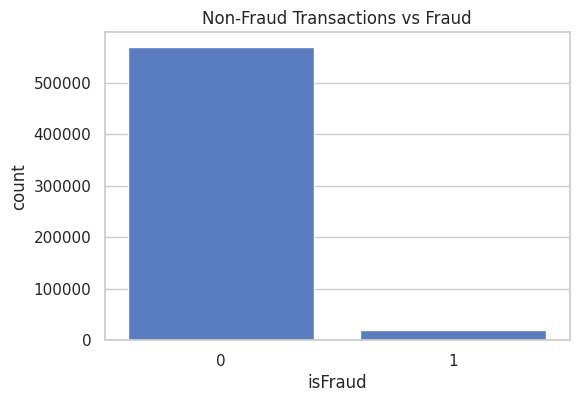

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
sns.countplot(x='isFraud', data=train)
plt.title('Non-Fraud Transactions vs Fraud')
plt.show()

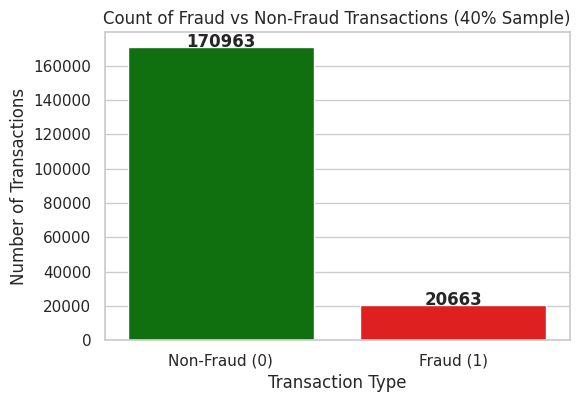

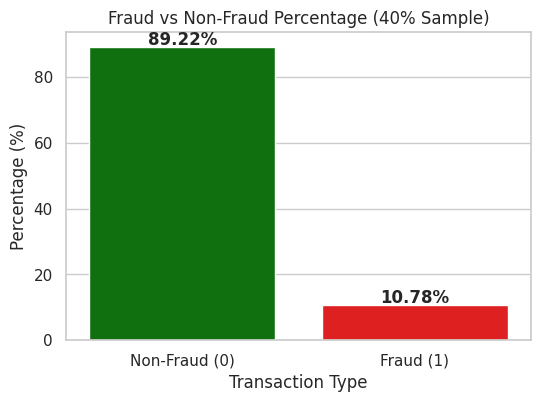

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# -----------------------------
# 1️⃣ Count of fraud vs non-fraud
# -----------------------------
plt.figure(figsize=(6,4))
sns.countplot(x='isFraud', data=train_sampled, palette=['green','red'])
plt.title('Count of Fraud vs Non-Fraud Transactions (40% Sample)')
plt.xlabel('Transaction Type')
plt.ylabel('Number of Transactions')
plt.xticks([0,1], ['Non-Fraud (0)','Fraud (1)'])
for i, v in enumerate(train_sampled['isFraud'].value_counts().sort_index()):
    plt.text(i, v + 50, str(v), ha='center', fontweight='bold')
plt.show()

# -----------------------------
# 2️⃣ Percentage of fraud vs non-fraud
# -----------------------------
fraud_percent = train_sampled['isFraud'].value_counts(normalize=True) * 100
plt.figure(figsize=(6,4))
sns.barplot(x=fraud_percent.index, y=fraud_percent.values, palette=['green','red'])
plt.title('Fraud vs Non-Fraud Percentage (40% Sample)')
plt.xlabel('Transaction Type')
plt.ylabel('Percentage (%)')
plt.xticks([0,1], ['Non-Fraud (0)','Fraud (1)'])
for i, v in enumerate(fraud_percent.values):
    plt.text(i, v + 0.5, f"{v:.2f}%", ha='center', fontweight='bold')
plt.show()

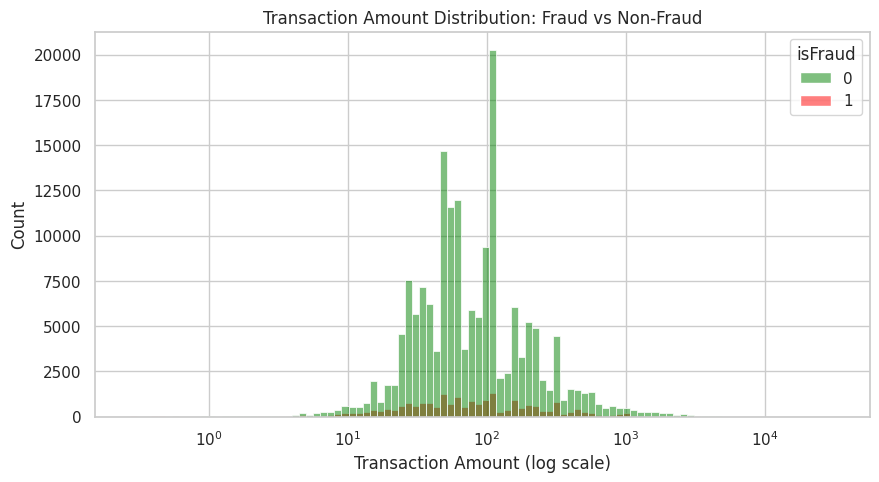

In [ ]:
plt.figure(figsize=(10,5))
sns.histplot(data=train_sampled, x='TransactionAmt', hue='isFraud', bins=100, log_scale=True, palette=['green','red'])
plt.title('Transaction Amount Distribution: Fraud vs Non-Fraud')
plt.xlabel('Transaction Amount (log scale)')
plt.ylabel('Count')
plt.show()

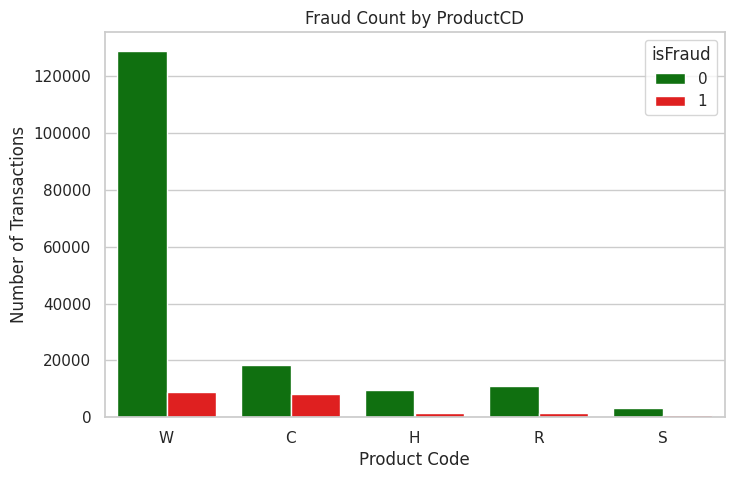

In [ ]:
plt.figure(figsize=(8,5))
sns.countplot(data=train_sampled, x='ProductCD', hue='isFraud', palette=['green','red'])
plt.title('Fraud Count by ProductCD')
plt.xlabel('Product Code')
plt.ylabel('Number of Transactions')
plt.show()

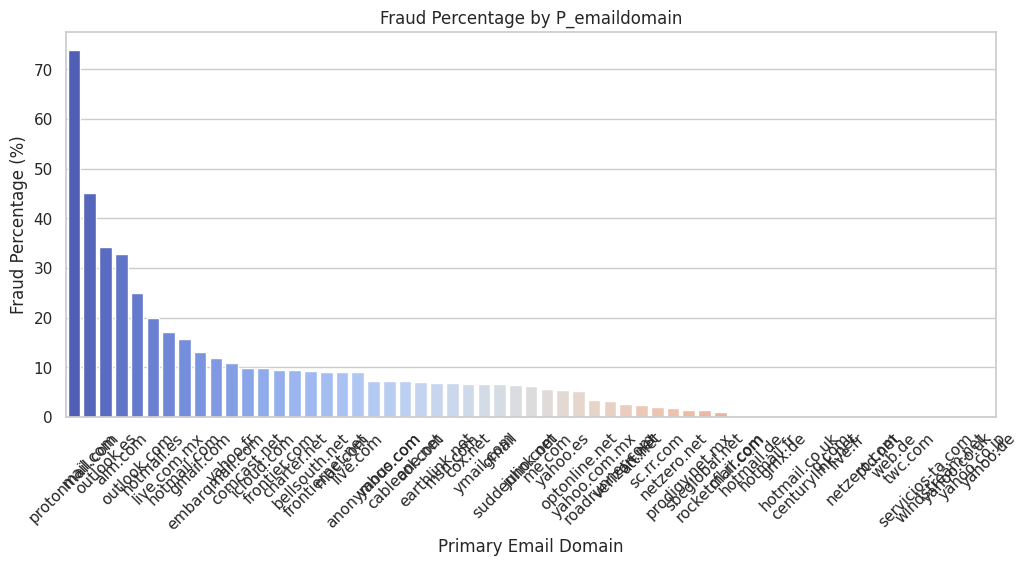

In [ ]:
email_fraud = train_sampled.groupby('P_emaildomain')['isFraud'].mean().sort_values(ascending=False)*100

plt.figure(figsize=(12,5))
sns.barplot(x=email_fraud.index, y=email_fraud.values, palette='coolwarm')
plt.title('Fraud Percentage by P_emaildomain')
plt.ylabel('Fraud Percentage (%)')
plt.xlabel('Primary Email Domain')
plt.xticks(rotation=45)
plt.show()

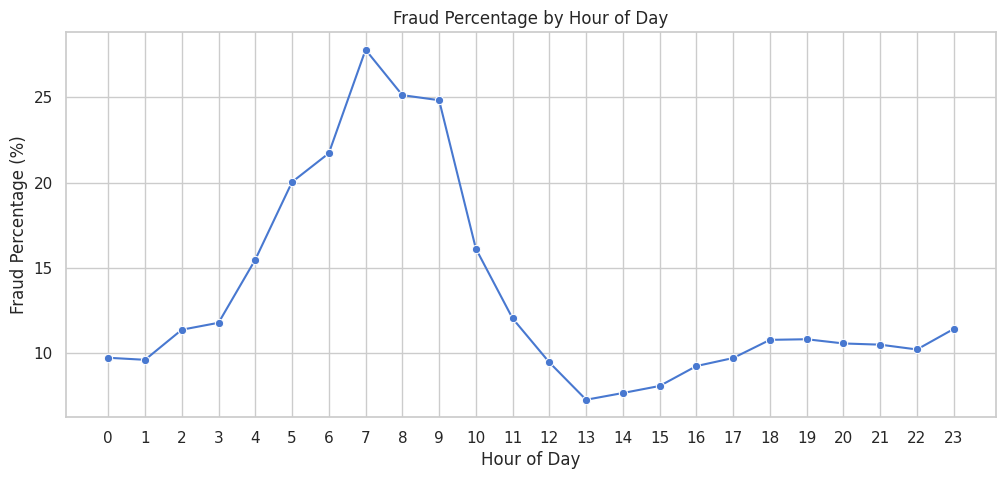

In [ ]:
train_sampled['hour'] = ((train_sampled['TransactionDT'] / 3600) % 24).astype(np.int8)
hourly_fraud = train_sampled.groupby('hour')['isFraud'].mean()*100

plt.figure(figsize=(12,5))
sns.lineplot(x=hourly_fraud.index, y=hourly_fraud.values, marker='o')
plt.title('Fraud Percentage by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Fraud Percentage (%)')
plt.xticks(range(0,24))
plt.show()

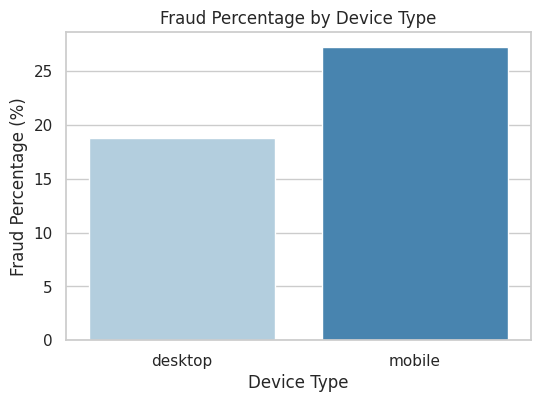

In [ ]:
device_fraud = train_sampled.groupby('DeviceType')['isFraud'].mean()*100

plt.figure(figsize=(6,4))
sns.barplot(x=device_fraud.index, y=device_fraud.values, palette='Blues')
plt.title('Fraud Percentage by Device Type')
plt.ylabel('Fraud Percentage (%)')
plt.xlabel('Device Type')
plt.show()

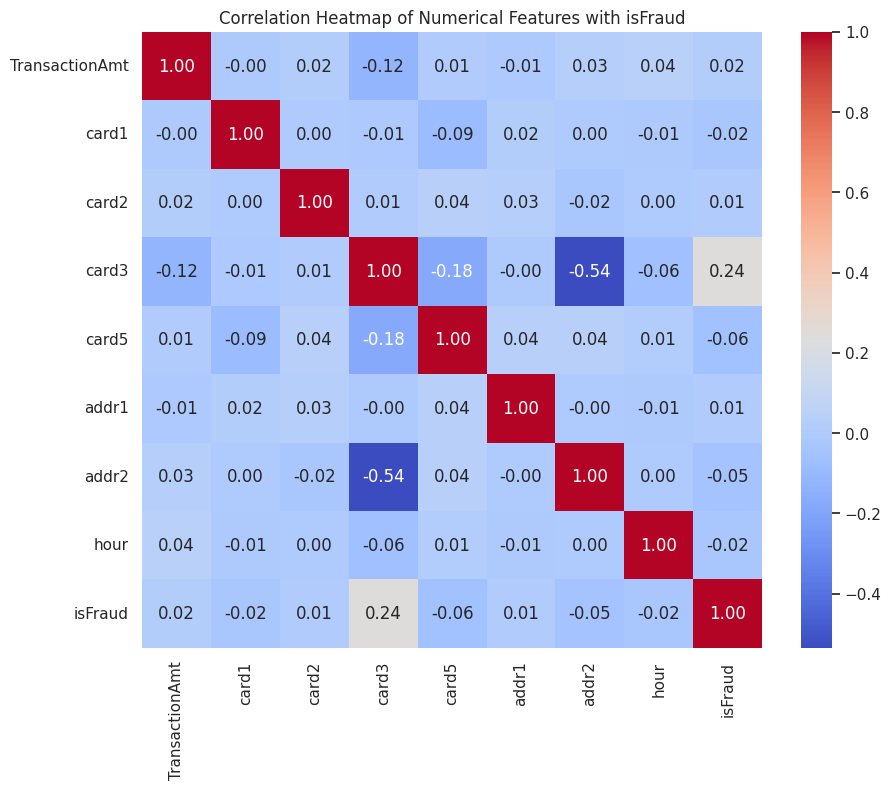

In [ ]:
num_cols = ['TransactionAmt','card1','card2','card3','card5','addr1','addr2','hour']
plt.figure(figsize=(10,8))
sns.heatmap(train_sampled[num_cols + ['isFraud']].corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Heatmap of Numerical Features with isFraud')
plt.show()

In [ ]:
# Count missing values per numeric column before filling
missing_before = train_sampled[num_cols].isnull().sum()
print("Missing values before filling:\n", missing_before)

Missing values before filling:
 TransactionAmt        0
card1                 0
card2              3007
card3               495
card5              1437
addr1             25272
addr2             25272
hour                  0
dtype: int64


In [ ]:
# Identify all numerical columns in train_sampled
numerical_cols_to_impute = train_sampled.select_dtypes(include=np.number).columns.tolist()

# Exclude 'TransactionID' and 'isFraud' from imputation as they are not features or target
numerical_cols_to_impute = [col for col in numerical_cols_to_impute if col not in ['TransactionID', 'isFraud']]

# Fill missing values in ALL identified numerical columns with their median
for col in numerical_cols_to_impute:
    if train_sampled[col].isnull().any():
        train_sampled[col] = train_sampled[col].fillna(train_sampled[col].median())

# For consistency, update the global 'num_cols' to reflect all numerical columns now imputed
# This also ensures the check in ot-0xowci2O7 would be more comprehensive if re-run.
num_cols = numerical_cols_to_impute

print("Missing values before filling: (Note: This is based on original 'num_cols' before comprehensive imputation)")
print(train_sampled[num_cols].isnull().sum())
print(f"Total NaN values after comprehensive numerical imputation: {train_sampled[numerical_cols_to_impute].isnull().sum().sum()}")

Missing values before filling: (Note: This is based on original 'num_cols' before comprehensive imputation)
TransactionDT     0
TransactionAmt    0
card1             0
card2             0
card3             0
card5             0
addr1             0
addr2             0
id_01             0
id_02             0
id_03             0
id_04             0
id_05             0
id_06             0
id_07             0
id_08             0
id_09             0
id_10             0
id_11             0
id_13             0
id_14             0
id_17             0
id_18             0
id_19             0
id_20             0
id_21             0
id_22             0
id_24             0
id_25             0
id_26             0
id_32             0
hour              0
dtype: int64
Total NaN values after comprehensive numerical imputation: 0


In [ ]:
#Fill missing values with 'Unknown'
cat_cols = train_sampled.select_dtypes(include=['object']).columns.tolist()
train_sampled[cat_cols] = train_sampled[cat_cols].fillna('Unknown')

In [ ]:
id_cols = [col for col in train_sampled.columns if 'id_' in col]

for col in id_cols:
    train_sampled[col + '_missing'] = train_sampled[col].isnull().astype('uint8')  # 1 if missing, 0 if present

In [ ]:
for col in cat_cols:
    le = LabelEncoder()
    train_sampled[col] = le.fit_transform(train_sampled[col].astype(str))

In [ ]:
# Log-transform TransactionAmt to reduce skew
train_sampled['TransactionAmt_log'] = np.log1p(train_sampled['TransactionAmt'])

# Standardize TransactionAmt per card1
train_sampled['TransactionAmt_by_card1'] = train_sampled['TransactionAmt'] / train_sampled.groupby('card1')['TransactionAmt'].transform('mean')

# Standardize TransactionAmt per DeviceInfo
train_sampled['TransactionAmt_by_device'] = train_sampled['TransactionAmt'] / train_sampled.groupby('DeviceInfo')['TransactionAmt'].transform('mean')

In [ ]:
from sklearn.preprocessing import StandardScaler

# Re-identify all numerical columns that are features (not TransactionID or isFraud)
# after all feature engineering and imputation steps, including newly created ones
features_to_scale = [col for col in train_sampled.select_dtypes(include=np.number).columns if col not in ['TransactionID', 'isFraud']]

scaler = StandardScaler()
train_sampled[features_to_scale] = scaler.fit_transform(train_sampled[features_to_scale])

In [ ]:
# Sort by time
train_sampled_sorted = train_sampled.sort_values("TransactionDT")

split_idx = int(len(train_sampled_sorted) * 0.8)

train_df = train_sampled_sorted.iloc[:split_idx]
test_df  = train_sampled_sorted.iloc[split_idx:]

X_train = train_df.drop(['isFraud', 'TransactionID'], axis=1)
y_train = train_df['isFraud']

X_test = test_df.drop(['isFraud', 'TransactionID'], axis=1)
y_test = test_df['isFraud']


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

from xgboost import XGBClassifier
from catboost import CatBoostClassifier

import pandas as pd

# -------------------------
# Assume 'train_sampled' is already prepared
# (undersampling + all fraud cases)
# -------------------------

X = train_sampled.drop(columns=['isFraud', 'TransactionID'])
y = train_sampled['isFraud']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# =========================================================
# 1️⃣ XGBoost
# =========================================================

# scale_pos_weight handles class imbalance
scale_pos_weight = y_train.value_counts()[0] / y_train.value_counts()[1]

xgb = XGBClassifier(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=scale_pos_weight,
    objective="binary:logistic",
    eval_metric="auc",
    random_state=42,
    n_jobs=-1
)

xgb.fit(X_train, y_train)

y_pred_xgb = xgb.predict(X_test)
y_pred_xgb_proba = xgb.predict_proba(X_test)[:, 1]

print("XGBoost")
print(confusion_matrix(y_test, y_pred_xgb))
print(classification_report(y_test, y_pred_xgb))
print("ROC-AUC:", roc_auc_score(y_test, y_pred_xgb_proba))

# =========================================================
# 2️⃣ CatBoost
# =========================================================

cat = CatBoostClassifier(
    iterations=500,
    learning_rate=0.05,
    depth=6,
    verbose=0,
    class_weights=[
        1,
        y_train.value_counts()[0] / y_train.value_counts()[1]
    ],
    random_state=42
)

cat.fit(X_train, y_train)

y_pred_cat = cat.predict(X_test)
y_pred_cat_proba = cat.predict_proba(X_test)[:, 1]

print("CatBoost")
print(confusion_matrix(y_test, y_pred_cat))
print(classification_report(y_test, y_pred_cat))
print("ROC-AUC:", roc_auc_score(y_test, y_pred_cat_proba))


XGBoost
[[30096  4097]
 [  982  3151]]
              precision    recall  f1-score   support

           0       0.97      0.88      0.92     34193
           1       0.43      0.76      0.55      4133

    accuracy                           0.87     38326
   macro avg       0.70      0.82      0.74     38326
weighted avg       0.91      0.87      0.88     38326

ROC-AUC: 0.9042208660989716
CatBoost
[[29010  5183]
 [ 1174  2959]]
              precision    recall  f1-score   support

           0       0.96      0.85      0.90     34193
           1       0.36      0.72      0.48      4133

    accuracy                           0.83     38326
   macro avg       0.66      0.78      0.69     38326
weighted avg       0.90      0.83      0.86     38326

ROC-AUC: 0.8682656163028517


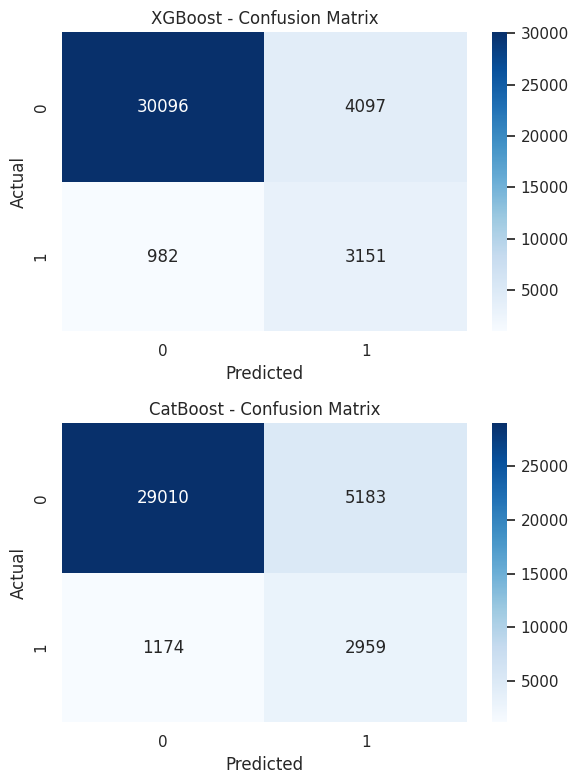

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

models = {
    "XGBoost": y_pred_xgb,
    "CatBoost": y_pred_cat
}

plt.figure(figsize=(6,8))

for i, (name, preds) in enumerate(models.items()):
    cm = confusion_matrix(y_test, preds)
    plt.subplot(2, 1, i + 1)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"{name} - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")

plt.tight_layout()
plt.show()


In [ ]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score

stack_model = StackingClassifier(
    estimators=[
        ('xgb', xgb),
        ('cat', cat)
    ],
    final_estimator=LogisticRegression(
        solver='liblinear',
        class_weight='balanced',
        random_state=42
    ),
    cv=5,                 # make CV explicit
    n_jobs=-1,
    passthrough=True,
    stack_method="predict_proba"  # ensures meta-model uses probabilities
)

stack_model.fit(X_train, y_train)

y_pred_proba = stack_model.predict_proba(X_test)[:, 1]

threshold = 0.3
y_pred = (y_pred_proba > threshold).astype(int)

print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_pred_proba))


Confusion Matrix:
 [[24259  9934]
 [  424  3709]]

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.71      0.82     34193
           1       0.27      0.90      0.42      4133

    accuracy                           0.73     38326
   macro avg       0.63      0.80      0.62     38326
weighted avg       0.91      0.73      0.78     38326

ROC-AUC: 0.9102737496505174


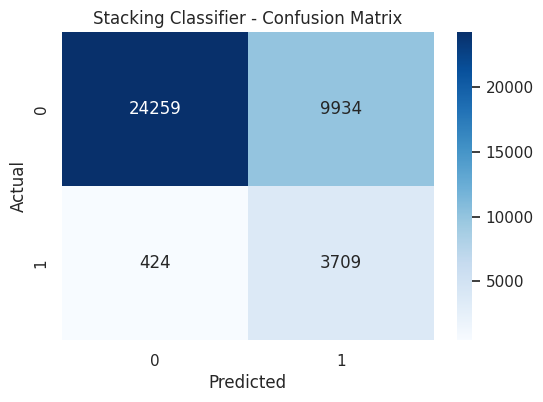

In [61]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Stacking Classifier - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


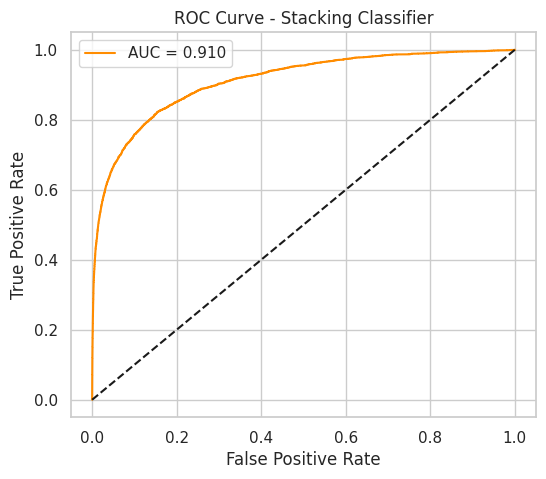

In [62]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}", color="darkorange")
plt.plot([0,1], [0,1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Stacking Classifier")
plt.legend()
plt.show()


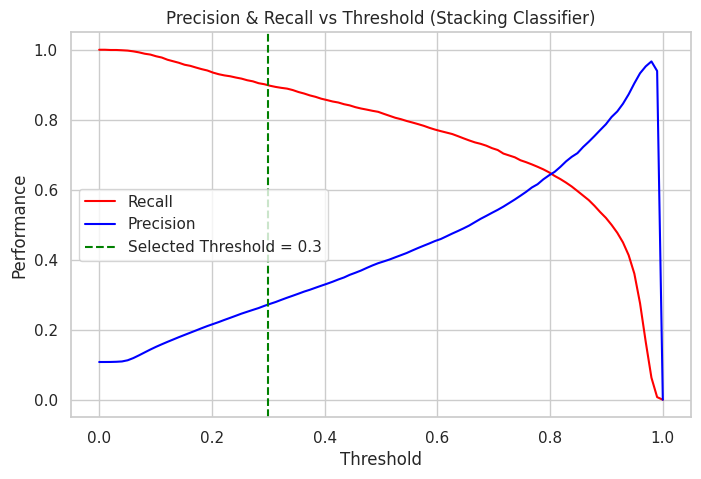

In [63]:
thresholds = np.linspace(0, 1, 100)
recalls = []
precisions = []

for t in thresholds:
    preds = (y_pred_proba > t).astype(int)
    cm = confusion_matrix(y_test, preds)
    TP = cm[1,1]
    FP = cm[0,1]
    FN = cm[1,0]
    precision_score = TP / (TP + FP + 1e-6)
    recall_score = TP / (TP + FN + 1e-6)
    recalls.append(recall_score)
    precisions.append(precision_score)

plt.figure(figsize=(8,5))
plt.plot(thresholds, recalls, label="Recall", color='red')
plt.plot(thresholds, precisions, label="Precision", color='blue')
plt.axvline(threshold, color='green', linestyle='--', label=f"Selected Threshold = {threshold}")
plt.xlabel("Threshold")
plt.ylabel("Performance")
plt.title("Precision & Recall vs Threshold (Stacking Classifier)")
plt.legend()
plt.show()


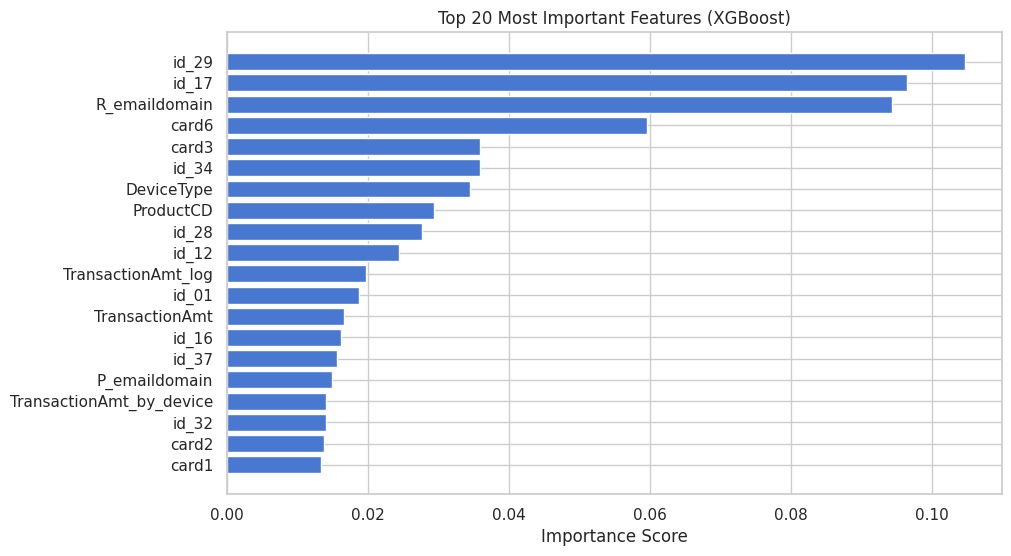

In [65]:
import pandas as pd
import matplotlib.pyplot as plt

# XGBoost feature importance
feature_imp_xgb = pd.DataFrame({
    "Feature": X_train.columns,
    "Importance": xgb.feature_importances_
}).sort_values(by="Importance", ascending=False).head(20)

plt.figure(figsize=(10, 6))
plt.barh(feature_imp_xgb["Feature"], feature_imp_xgb["Importance"])
plt.gca().invert_yaxis()
plt.title("Top 20 Most Important Features (XGBoost)")
plt.xlabel("Importance Score")
plt.show()
